In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split

from astropy.io import fits
import numpy as np
import glob

import sys
sys.path.append('../utilities')
from utilities import *
from mask_generator import *

import multiprocessing
num_cores = multiprocessing.cpu_count()
from joblib import parallel_backend, Parallel, delayed
from dask.distributed import Client
client = Client()

2023-09-08 18:29:33.204882: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-08 18:29:33.222401: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 18:29:33.357314: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 18:29:33.358186: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 18:29:34.045413: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

#### **Read FITS files : cloudy and clear (= synthetic) images**

In [2]:
def read_fits_data(filename, shape=(128, 160)):
    data = fits.getdata(filename)
    data = rebin(data, shape)
    return data

cloud_images_names = glob.glob('../../CLASSIFICATION_TEST/CLOUD/*.fits')
clear_images_names = glob.glob('../../CLASSIFICATION_TEST/SIM_CLEAR/*.fits')

In [3]:
with parallel_backend('threading', n_jobs=num_cores):
    cloud_images_data = Parallel(verbose=5)(delayed(read_fits_data)(filename = filename) for filename in cloud_images_names)

cloud_images_data = np.array(cloud_images_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 1413 out of 1413 | elapsed:    2.6s finished


In [4]:
with parallel_backend('threading', n_jobs=num_cores):
    clear_images_data = Parallel(verbose=5)(delayed(read_fits_data)(filename = filename) for filename in clear_images_names)

clear_images_data = np.array(clear_images_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    3.8s finished


In [5]:
cloud_images_data.shape, clear_images_data.shape

((1413, 128, 160), (2000, 128, 160))

#### **Data pre-processing : split into test, train, validation + normalize + create truth labels**

In [6]:
# Normalize pixel values to be between 0 and 1
norm = 2**14
cloud_images_data, test_images = cloud_images_data / norm, clear_images_data / norm

In [7]:
# 1 = cloud
# 0 = clear

cloud_labels = np.array(np.full(len(cloud_images_data), 1), dtype=np.uint8).reshape(-1, 1)
clear_labels = np.array(np.full(len(clear_images_data), 0), dtype=np.uint8).reshape(-1, 1)

In [8]:
train = np.concatenate([cloud_images_data, clear_images_data])
targets = np.concatenate([cloud_labels, clear_labels])

In [9]:
train.shape, targets.shape

((3413, 128, 160), (3413, 1))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train, targets, test_size=0.2, random_state=21)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.2, random_state=21)
X_train.shape, X_test.shape, X_valid.shape

((2730, 128, 160), (546, 128, 160), (137, 128, 160))

#### **Function to detect if GPU is available and does black magic**

In [13]:
# Function to get hardware strategy
def get_hardware_strategy():
    try:
        # TPU detection. No parameters necessary if TPU_NAME environment variable is
        # set: this is always the case on Kaggle.
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        tf.config.optimizer.set_jit(True)
    else:
        # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()

    return tpu, strategy

tpu, strategy = get_hardware_strategy()

In [14]:
# Define the VGG-8 model
model_VGG8 = Sequential([
    # Convolutional Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 160, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Convolutional Block 2
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Convolutional Block 3
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification, so use 'sigmoid' activation
])


In [15]:
EPOCHS = 10 # number of epochs per trial
BATCH_SIZE = 32 # batch size

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy']

model_VGG8.compile(optimizer=optimizer, loss=loss, metrics=metrics)


# Compile the mode

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0.01, mode='auto', baseline=None, restore_best_weights=True, verbose=1)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.0001 * 0.5 ** (epoch // 10) , verbose=1)

history = model_VGG8.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[lr_schedule, early_stopping],
                            validation_data=(X_test, y_test), verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/10
86/86 [==============================] - 51s 588ms/step - loss: 0.3916 - accuracy: 0.9454 - val_loss: 0.0359 - val_accuracy: 1.0000 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/10
86/86 [==============================] - 54s 632ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 2.0745e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/10
86/86 [==============================] - 55s 645ms/step - loss: 8.6552e-06 - accuracy: 1.0000 - val_loss: 1.5178e-06 - val_accuracy: 1.0000 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/10
86/86 [==============================] - 54s 623ms/step - loss: 1.0136e-06 - accuracy: 1.0000 - val_loss: 5.7121e-07 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4: early stopping


In [17]:
model_VGG8.save('../models/image_classification_VGG8.keras', overwrite=True)
#model = keras.models.load_model('../models/image_classification_VGG8.keras')

#### **Metrics and other evaluation things...**

ValueError: x and y must have same first dimension, but have shapes (10,) and (4,)

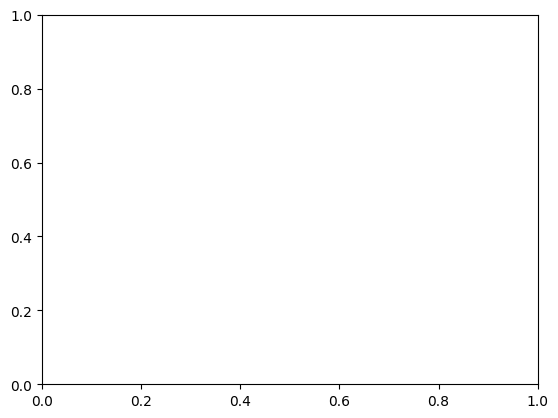

In [18]:
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
H = history
plt.figure()

plt.plot(N, history.history['accuracy'], label='train_acc')
plt.plot(N, history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(N, history.history['loss'], label = 'train_loss')
plt.plot(N, history.history['val_loss'], label = 'val_loss')
plt.title("Training/Validation Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

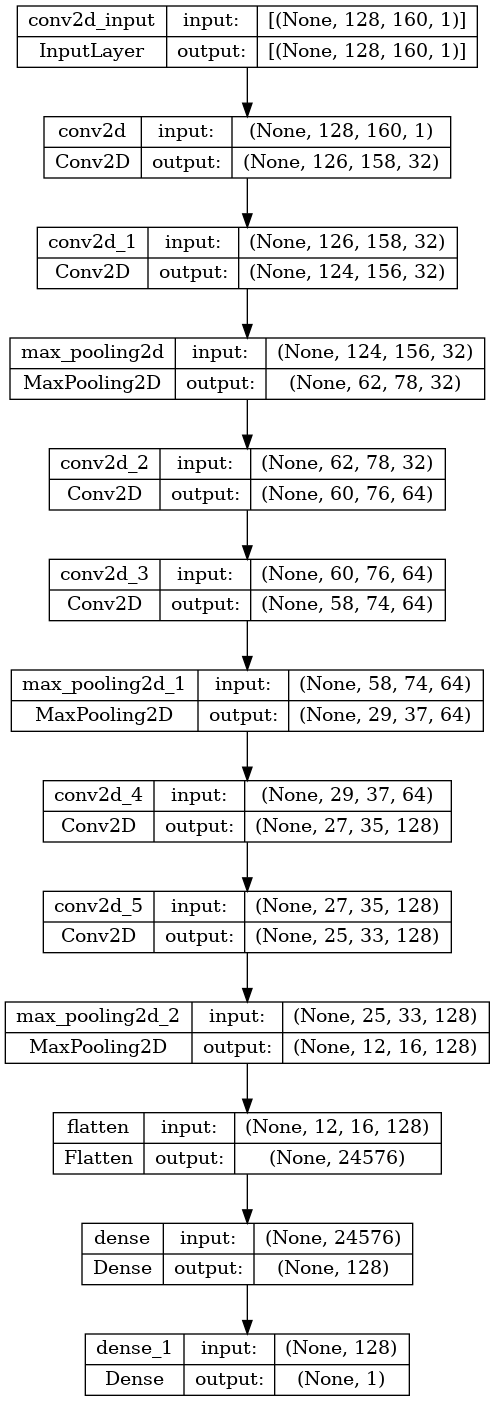

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model_VGG8, show_shapes=True, show_layer_names=True)

In [21]:
import visualkeras

visualkeras.layered_view(model_VGG8).show() # display using your system viewer
#visualkeras.layered_view(model, to_file='output.png') # write to disk
#visualkeras.layered_view(model, to_file='output.png').show() # write and show

kf.service.services: KApplicationTrader: mimeType "x-scheme-handler/file" not found
kf.service.services: KApplicationTrader: mimeType "x-scheme-handler/file" not found
org.kde.kdegraphics.gwenview.lib: Unresolved mime type  "image/x-mng"
org.kde.kdegraphics.gwenview.lib: Unresolved raw mime type  "image/x-nikon-nrw"
org.kde.kdegraphics.gwenview.lib: Unresolved raw mime type  "image/x-samsung-srw"
